# Main Notebook for Training Models and Generating Figures

### Here are some flags which will affect the way the notebook executes and what data is written.

In [15]:
# Runs notebook in a mode which uses max-normalized spectra 
#(figures for this can be found in the paper's supplemental information.)
# Maintext figures set this variable to FALSE.
use_max_normalized = False
norm_str = 'max' if use_max_normalized else 'feff_cnn_origninal'

# Flag for using validation data (for model characterization)
# or testing data (should only be done once the previous process is complete).
# Default to testing data.
use_test = True

# Set random seed to be used as argument for other functions.
rseed = 42

In [19]:
%matplotlib inline

import sys
import os
import sklearn
import json
import numpy as np
from collections import Counter
from scipy.stats import norm
from typing import List

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

from pprint import pprint

from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator

#sys.path.append(os.path.join(os.getcwd(), '..'))  # TRIXS path if not automatically detected
#from trixs.machine_learning.benchmarks import precision_recall_matrix, confusion_dict

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from trixs.spectra.spectrum_featurize import polynomialize_by_idx, gauge_polynomial_error

import pandas

storage_directory = './spectral_data'
figure_write_folder = "./figures_feffnorm" if not use_max_normalized else './figures_maxnorm'
try: 
    os.mkdir(figure_write_folder) 
except OSError as error: 
    pass
np.random.seed(rseed)

In [17]:
print("The publication uses SKlearn version 0.21.3. Yours:",sklearn.__version__)

The publication uses SKlearn version 0.21.3. Yours: 0.23.1


## Define domains which will be used for x-axis labels later, as well as define the elements which will be imported for use

In [5]:
target_elements_groups=[('Ti','O'),('V','O'),('Cr','O'),
                        ('Mn','O'),('Fe','O'),('Co','O'),
                        ('Ni','O'),('Cu','O')]

x_domains = {  ('Co','O'):  np.linspace(7713.5, 7765.83,100),
               ('Fe','O'): np.linspace(7115.0, 7167.764,100),
               ('V','O'):  np.linspace(5468.0, 5520.631,100),
               ('Cu','O'): np.linspace( 8987.5, 9039.712,100),
               ('Ni','O'): np.linspace( 8336.5 ,8388.723,100),
               ('Cr','O'): np.linspace(5993.1, 6045.686,100),
               ('Mn','O'): np.linspace(6541.7, 6594.417,100),
               ('Ti','O'): np.linspace(4969.0, 5021.024,100)}

colors_by_pair = {('Ti','O'):'orangered',
                  ('V','O'):'darkorange',
                  ('Cr','O'):'gold',
                  ('Mn','O'):'seagreen',
                  ('Fe','O'):'dodgerblue',
                  ('Co','O'):'navy',
                  ('Ni','O'):'rebeccapurple',
                  ('Cu','O'):"mediumvioletred"}

pair_to_name={'Ti':"Titanium",'V':'Vanadium',
              'Cr':'Chromium','Mn':"Manganese",
              'Fe':"Iron",'Co':"Cobalt",
             'Ni':'Nickel','Cu':'Copper'}

# Load in Pointwise Data

# Set up Precision / Recall Matrix

In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def precision_recall(fits: List, labels: List, target)->List[float]:
    """
    Computes the precision and recall and F1 score
    for an individual class label 'target',
    which can be any object with an equivalence relation via ==
    :param fits:
    :param labels:
    :param target:
    :return:
    """
    N = len(labels)

    # Generate the counts of true and false positives
    true_positives = len([True for i in range(N)
                          if (fits[i] == target and labels[i] == target)])
    false_positives = len([True for i in range(N)
                           if (fits[i] == target and labels[i] != target)])
    false_negatives = len([True for i in range(N)
                           if (fits[i] != target and labels[i] == target)])

    if true_positives == 0:
        return [0, 0, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2.0 * precision * recall / (precision + recall)
    return [precision, recall, f1]


def precision_recall_matrix(fits: List, labels: List, classes: List):
    """
    Computes the precision and recall and F1 score for a set of classes at once

    :param fits:
    :param classes:
    :param labels:
    :return:
    """
    results = []
    for cls in classes:
        results.append(precision_recall(fits, labels, cls))
    return np.array(results)

def avg_f1_score(guesses,labels):
    f1_score = precision_recall_matrix(guesses,labels,[4,5,6])
    return np.mean([np.round(100*x[2],1) for x in f1_score])

# Load in Train/Test sets

In [7]:

# TT stands for Train-Test
# c = coord, b = bader, md = mean distance
ttc_by_pair = {pair:{} for pair in target_elements_groups}
ttb_by_pair = {pair:{} for pair in target_elements_groups}
ttmd_by_pair = {pair:{} for pair in target_elements_groups}

for pair in target_elements_groups:
    for key in ['train_x','train_y','valid_x','valid_y','test_x','test_y']:
        ttc_by_pair[pair][key] =np.load(f'./model_data/{pair[0]}_coord_{key}.npy')
        ttb_by_pair[pair][key] =np.load(f'./model_data/{pair[0]}_bader_{key}.npy')
        ttmd_by_pair[pair][key] =np.load(f'./model_data/{pair[0]}_md_{key}.npy')
        
# Quickly normalize the input X spectra if toggled at top of notebook.
if use_max_normalized:
    for pair in target_elements_groups:
        for key in ['train_x','valid_x','test_x']:
            ttc_by_pair[pair][key] = np.array([array / np.max(array) for array in ttc_by_pair[pair][key][:]])
            ttb_by_pair[pair][key] = np.array([array / np.max(array) for array in ttb_by_pair[pair][key][:]])
            ttmd_by_pair[pair][key] = np.array([array / np.max(array) for array in ttmd_by_pair[pair][key][:]])
            


# Main Cell 1:
# Random Forests Trained using Pointwise spectra

Commencing run...


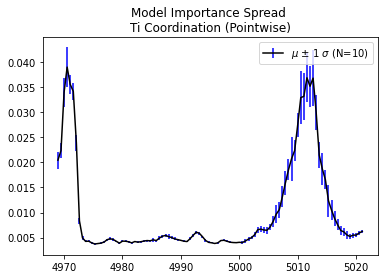

Done with Coordination for  ('Ti', 'O')


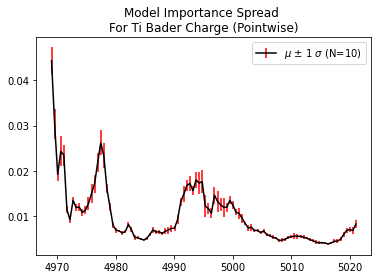

Done with Bader for  ('Ti', 'O')


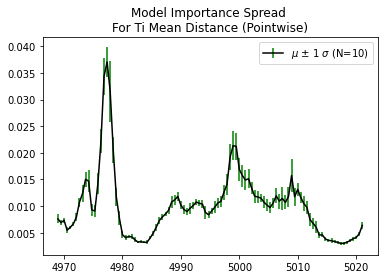

Done with mean distance


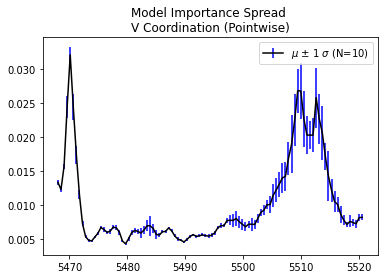

Done with Coordination for  ('V', 'O')


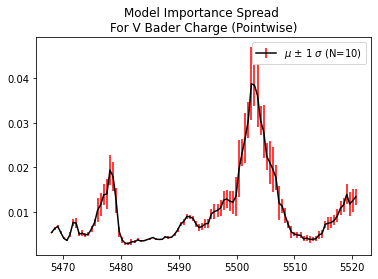

Done with Bader for  ('V', 'O')


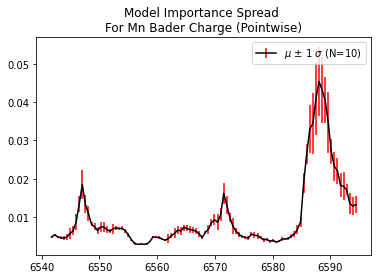

Done with Bader for  ('Mn', 'O')


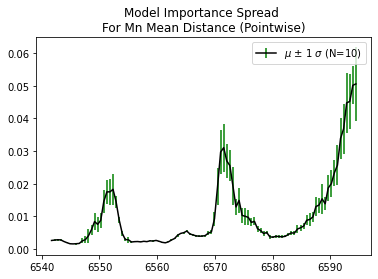

Done with mean distance


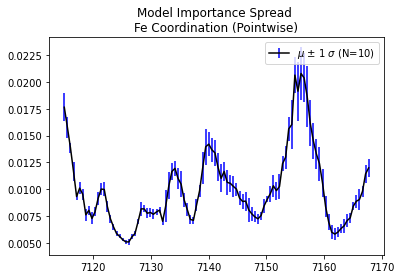

Done with Coordination for  ('Fe', 'O')


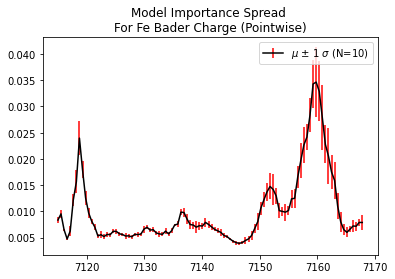

Done with Bader for  ('Fe', 'O')


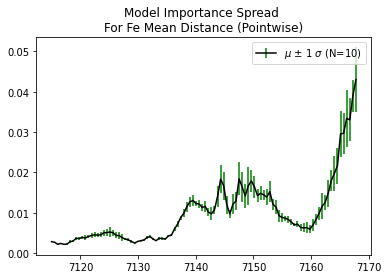

Done with mean distance


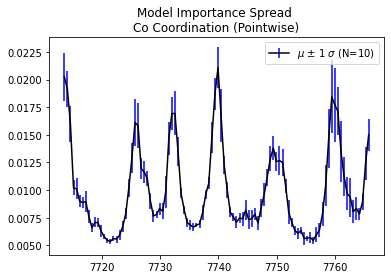

Done with Coordination for  ('Co', 'O')


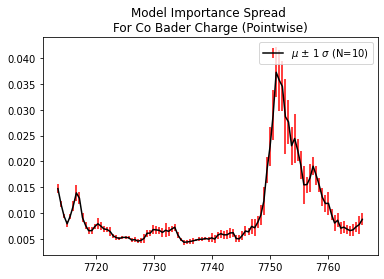

Done with Bader for  ('Co', 'O')


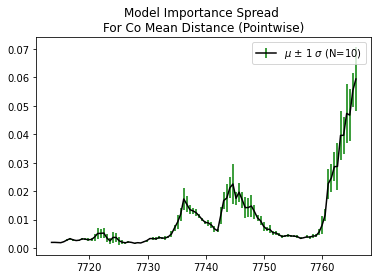

Done with mean distance


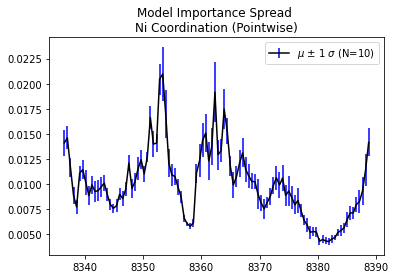

Done with Coordination for  ('Ni', 'O')


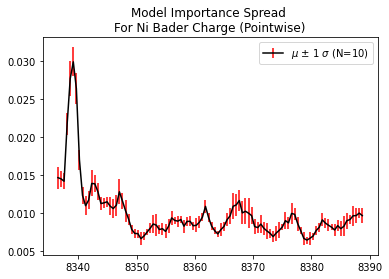

Done with Bader for  ('Ni', 'O')


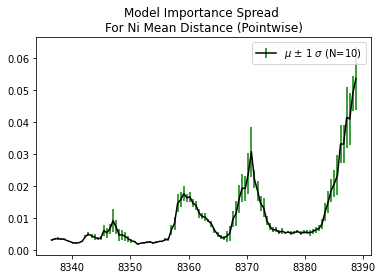

Done with mean distance


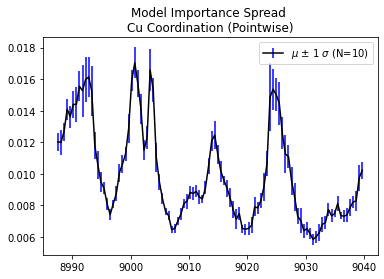

Done with Coordination for  ('Cu', 'O')


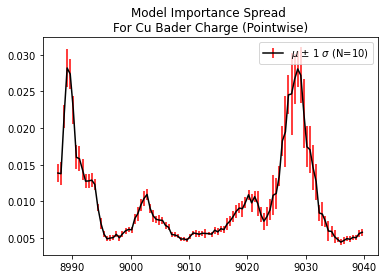

Done with Bader for  ('Cu', 'O')


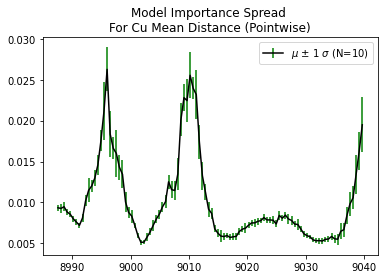

Done with mean distance


In [8]:
# Flag to run or not run the cell
run = True
# Flag to display plots inline
show_plots = False
print("Commencing run...")

accuracies = {}
deviations = {}
all_data_values = []

md_perf_by_pair={}
bader_perf_by_pair={}
models_by_pair = {}
means_by_pair = {}


use_test = True

# Flags for your own experimentaion purposes if you'd like to focus on one task or another.
# N O T E ! The rest of the notebook assumes all three flags are on!
run_coord = True
run_bader = True
run_md = True

# How many times to repeat the training of the random forests 
# with different random seeds used
# for the training, to generate error bars 
# on the feature RANKing (hence, RANK REPEAT).

# The publication uses 10 total trainings, so RANK_REPEAT is set here to 9.
RANK_REPEAT = 9


# The hyperparameter N_ESTIMATORS is controllable here because running the notebook with
# a smaller number of estimators may be desirable to verify that things are working.
# Set to 300 by default-- as was used in the publication.

N_ESTIMATORS = 300

for pair in target_elements_groups:
    if not run:
        continue
    
    # Instantiate each random forest model
    
    forest_c = RandomForestClassifier(random_state=rseed,
                                      n_estimators=N_ESTIMATORS,
                                      max_depth =35, 
                                     max_features = 8, min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     class_weight=None,
                                     n_jobs=4)

    forest_b = RandomForestRegressor(random_state=rseed,
                      criterion='mse',max_depth=35,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=N_ESTIMATORS,
                                    n_jobs=4)
    
    
    forest_md = RandomForestRegressor(random_state=rseed,
                      criterion='mse',max_depth=35,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=N_ESTIMATORS,
                                     n_jobs=4)
        
    #############################################
    # COORDINATION
    #############################################
    
    xc_train = ttc_by_pair[pair]['train_x'] 
    yc_train = ttc_by_pair[pair]['train_y'] 

    if use_test:
        xc_valid = ttc_by_pair[pair]['test_x']
        yc_valid = ttc_by_pair[pair]['test_y'] 
    else:
        xc_valid = ttc_by_pair[pair]['valid_x'] 
        yc_valid = ttc_by_pair[pair]['valid_y']
    
        
    
    if run_coord:
        forest_c.fit(xc_train,yc_train)

        ################## FEATURE RANKING VARIANCE INTERLUDE ######################

        cur_model_f1s = [[x[2]*100 for x in  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])]]
        cur_model_accuracies = [forest_c.score(xc_valid,yc_valid)]
        cur_model_importances = [forest_c.feature_importances_] 

        for i in range(RANK_REPEAT):
            forest_c.random_state = rseed+i+1
            forest_c.fit(xc_train,yc_train)
            cur_model_importances.append(forest_c.feature_importances_)
            cur_model_accuracies.append(forest_c.score(xc_valid,yc_valid))
            cur_model_f1s.append([x[2]*100 for x in
                                  precision_recall_matrix(forest_c.predict(xc_valid),yc_valid,[4,5,6])])

        importances_mean = np.mean(cur_model_importances,axis=0)
        coord_accuracies_mean = np.mean(cur_model_accuracies)
        coord_f1s_mean = np.mean(cur_model_f1s, axis=0)

        if RANK_REPEAT:
            importances_std = np.std(cur_model_importances,axis=0)
            coord_accuracies_std = np.std(cur_model_accuracies)
            coord_f1s_std = np.std(cur_model_f1s,   axis=0)

        else:
            importances_std = np.zeros(len(cur_model_importances))
            coord_accuracies_std = np.zeros(len(cur_model_accuracies))
            coord_f1s_std = np.zeros(len(cur_model_f1s))


        means_by_pair[str(pair)+'-coord'] = importances_mean

        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='black',ecolor='blue')
        plt.title("Model Importance Spread \n{} Coordination (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig(figure_write_folder+'/{}_{}_all_coord_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()


        # Store the last model trained for later 
        # use in comparing against polynomial models.
        models_by_pair[str(pair)+'-Coord'] = forest_c

        print("Done with Coordination for ",pair)
        
        class_makeup = Counter(yc_valid)
        mode_guess_score = max(class_makeup.values())/sum(class_makeup.values())
    #############################################
    # BADER
    #############################################
    
    xb_train =  ttb_by_pair[pair]['train_x']
    yb_train =  ttb_by_pair[pair]['train_y']
    
    if use_test:
        xb_valid = ttb_by_pair[pair]['test_x']
        yb_valid = ttb_by_pair[pair]['test_y']
    else:
        xb_valid = ttb_by_pair[pair]['valid_x']
        yb_valid = ttb_by_pair[pair]['valid_y']
    
    if run_bader:
        forest_b.fit(xb_train,yb_train)    

        cur_model_importances = [forest_b.feature_importances_] 
        cur_model_accuracies = [forest_b.score(xb_valid,yb_valid)]
        cur_model_maes = [np.mean(np.abs(forest_b.predict(xb_valid) - yb_valid))]

        for i in range(RANK_REPEAT):
            forest_b.random_state = rseed+i+1
            forest_b.fit(xb_train,yb_train)
            cur_model_importances.append(forest_b.feature_importances_)
            cur_model_accuracies.append(forest_b.score(xb_valid,yb_valid))
            cur_model_maes.append(np.mean(np.abs(forest_b.predict(xb_valid) - yb_valid)))


        importances_mean = np.mean(cur_model_importances,axis=0)
        bader_accuracies_mean  = np.mean(cur_model_accuracies)
        bader_maes_mean = np.mean(cur_model_maes)

        if RANK_REPEAT:
            importances_std  = np.std(cur_model_importances,axis=0)
            bader_accuracies_std   = np.std(cur_model_accuracies)
            bader_maes_std = np.std(cur_model_maes)
        else:
            importances_std = np.zeros(len(cur_model_importances))
            bader_accuracies_std = np.zeros(len(cur_model_accuracies))
            bader_maes_std = np.zeros(len(cur_model_maes))


        accuracies[str(pair)+'-Bader'] = bader_accuracies_mean
        deviations[str(pair)+'-Bader'] = bader_accuracies_std
        means_by_pair[str(pair)+'-Bader'] = importances_mean

        plt.errorbar(x_domains[pair],importances_mean, yerr=importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='black',ecolor='red')
        plt.title("Model Importance Spread \nFor {} Bader Charge (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig(figure_write_folder+'/{}_{}_all_bader_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')

        plt.show()

        # Store the last model trained for later 
        # use in comparing against polynomial models.
        models_by_pair[str(pair)+'-Bader'] = forest_b

        bader_perf_by_pair[pair[0]+'-guesses'] = forest_b.predict(xb_valid)
        bader_perf_by_pair[pair[0]+'-labels'] = yb_valid

        print("Done with Bader for ",pair)

    ##############################
    #   MD PART
    ##############################

    xmd_train = np.array(ttmd_by_pair[pair]['train_x'])
    ymd_train = np.array(ttmd_by_pair[pair]['train_y'])
    
    if use_test:
        xmd_valid = np.array(ttmd_by_pair[pair]['test_x'])
        ymd_valid = np.array(ttmd_by_pair[pair]['test_y'])
    else:
        xmd_valid = np.array(ttmd_by_pair[pair]['valid_x'])
        ymd_valid = np.array(ttmd_by_pair[pair]['valid_y'])
    
    md_perf_by_pair[pair[0]+'-labels'] = ymd_valid
    
    if run_md:
        forest_md.fit(xmd_train,ymd_train)    

        cur_model_importances = [forest_md.feature_importances_] 
        cur_model_accuracies = [forest_md.score(xmd_valid,ymd_valid)]
        cur_model_maes = [np.mean(np.abs(forest_md.predict(xmd_valid) - ymd_valid))]

        for i in range(RANK_REPEAT):
            forest_md.random_state = rseed+i+1
            forest_md.fit(xmd_train,ymd_train)
            cur_model_importances.append(forest_md.feature_importances_)
            cur_model_accuracies.append(forest_md.score(xmd_valid,ymd_valid))
            cur_model_maes.append(np.mean(np.abs(forest_md.predict(xmd_valid) - ymd_valid)))


        importances_mean = np.mean(cur_model_importances,axis=0)
        md_accuracies_mean  = np.mean(cur_model_accuracies,axis=0)
        md_maes_mean = np.mean(cur_model_maes,axis=0)

        if RANK_REPEAT:

            importances_std  = np.std(cur_model_importances,axis=0)
            md_accuracies_std   = np.std(cur_model_accuracies,axis=0)
            md_maes_std = np.std(cur_model_maes,axis=0)
        else:
            importances_std  = np.zeros(len(cur_model_importances),axis=0)
            md_accuracies_std   = np.zeros(len(cur_model_accuracies),axis=0)
            md_maes_std = np.zeros(len(cur_model_maes),axis=0)

        means_by_pair[str(pair)+'-md'] = importances_mean

        plt.errorbar(x_domains[pair],importances_mean,yerr= importances_std,label='$\mu$ $\pm$ 1 $\sigma$ (N=10)',
                    color='black',ecolor='green')
        plt.title("Model Importance Spread \nFor {} Mean Distance (Pointwise)".format(pair[0]))
        plt.legend()
        plt.savefig(figure_write_folder+'/{}_{}_all_md_mean_importances.pdf'.format(pair[0],norm_str),format='pdf',dpi=300,transparent=True,bbox_inches='tight')
        plt.show()



        models_by_pair[str(pair)+'-Mean'] = forest_md

        # Used in constructing parity plots later

        md_perf_by_pair[pair[0]+'-guesses'] = forest_md.predict(xmd_valid)    

    
        print("Done with mean distance")
        
    if not (run_bader and run_md and run_coord):
        continue
    

    

    
    if RANK_REPEAT:
        #AVERAGES
        accuracies[str(pair)+'-Coord'] = np.round(coord_accuracies_mean*100,4)
        accuracies[str(pair)+'-Coord-F1'] = np.round(coord_f1s_mean,2)
        accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score*100,2)
        
        accuracies[str(pair)+'-Bader'] = np.round(bader_accuracies_mean*100,4)
        accuracies[str(pair)+'-Bader-MAE'] = np.round(bader_maes_mean,2)
        
        accuracies[str(pair)+'-MeanDist'] = np.round(md_accuracies_mean*100,4)
        accuracies[str(pair)+'-MeanDist-MAE'] = np.round(md_maes_mean,3)
        
        # DEVIATIONS
        deviations[str(pair)+'-Coord'] = np.round(coord_accuracies_std*100,4)
        deviations[str(pair)+'-Coord-F1'] = np.round(coord_f1s_std,4)
        
        deviations[str(pair)+'-Bader'] = np.round(bader_accuracies_std*100,4)
        deviations[str(pair)+'-Bader-MAE'] = np.round(bader_maes_std,4)
        
        deviations[str(pair)+'-MeanDist'] = np.round(md_accuracies_std*100,4)
        deviations[str(pair)+'-MeanDist-MAE'] = np.round(md_maes_std,4)
        
        
    
    else:
        accuracies[str(pair)+'-Coord'] = np.round(forest_c.score(xc_valid,yc_valid),2)
        accuracies[str(pair)+'-Coord-F1'] = np.round(avg_f1_score(guesses=guesses,labels=yc_valid),2)
        accuracies[str(pair)+'-GuessMode'] = np.round(mode_guess_score,2)
        
        accuracies[str(pair)+'-Bader'] = np.round(forest_b.score(xb_valid,yb_valid),2)
        accuracies[str(pair)+'-Bader-MAE'] = np.round(np.abs(forest_b.predict(xb_valid)-yb_valid).mean(),2)
        
        accuracies[str(pair)+'-MeanDist'] = np.round(forest_md.score(xmd_valid,ymd_valid),2)
        accuracies[str(pair)+'-MeanDist-MAE'] = np.round(np.abs(forest_md.predict(xmd_valid)-ymd_valid).mean(),2)
                         
        deviations[str(pair)+'-Coord'] = 0
        deviations[str(pair)+'-Coord-F1'] = 0
        deviations[str(pair)+'-GuessMode'] =0
        
        deviations[str(pair)+'-Bader'] = 0
        deviations[str(pair)+'-Bader-MAE'] = 0
        
        deviations[str(pair)+'-MeanDist'] =0
        deviations[str(pair)+'-MeanDist-MAE'] = 0
                                  
    
    all_data_values.append([pair[0],
                            accuracies[str(pair)+'-Coord'],
                            deviations[str(pair)+'-Coord'],
                            accuracies[str(pair)+'-Coord-F1'],
                            deviations[str(pair)+'-Coord-F1'],
                            accuracies[str(pair)+'-GuessMode'],
                            accuracies[str(pair)+'-Bader'],
                            deviations[str(pair)+'-Bader'],
                            accuracies[str(pair)+'-Bader-MAE'],
                            deviations[str(pair)+'-Bader-MAE'],
                            accuracies[str(pair)+'-MeanDist'],
                            deviations[str(pair)+'-MeanDist'],
                            accuracies[str(pair)+'-MeanDist-MAE'],
                            deviations[str(pair)+'-MeanDist-MAE']]
                          )
    
    

# Generate Performance Table

In [9]:
headers=['Material', 
         'Coord Baseline', 
         'Coord Acc.',
         'Coord F1 (4)','Coord F1 (5)','Coord F1 (6)',
         'Bader $R^2$', 
         'Bader MAE', 
         'Mean NN $R^2$',
         'Mean NN-MAE',]

f = open(figure_write_folder+'/pointwise_table_{}.csv'.format(norm_str),'w')
print(str(headers).strip('[').strip(']').replace("'",""))
f.write(str(headers).strip('[').strip(']').replace("'","")+'\n')
avgs = [0 for _ in range(len(headers))]

for pair in target_elements_groups:
    i=1
    
    elt = pair[0]
    
    the_str = elt+','
    
    the_str += "%.2f" %accuracies[str(pair)+'-GuessMode'] +','
    avgs[i] += accuracies[str(pair)+'-GuessMode']; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord'] +' $\pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord']  +','
    avgs[i] += accuracies[str(pair)+'-Coord']; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][0] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][0] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][0]; i+=1;

    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][1] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][1] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][1]; i+=1;
    
    the_str += "%.2f" %accuracies[str(pair)+'-Coord-F1'][2] + ' $ \pm$ '
    the_str += "%.2f" %deviations[str(pair)+'-Coord-F1'][2] + ', '
    avgs[i] += accuracies[str(pair)+'-Coord-F1'][2]; i+=1;



    
    the_str += "%.2f" %accuracies[str(pair)+'-Bader'] +' $\pm$'
    the_str += "%.2f" %deviations[str(pair)+'-Bader'] +','
    avgs[i] += accuracies[str(pair)+'-Bader']; i+=1;

    
    the_str += "%.3f" %accuracies[str(pair)+'-Bader-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations[str(pair)+'-Bader-MAE'] +' , '
    avgs[i] += accuracies[str(pair)+'-Bader-MAE']; i+=1;


    the_str += "%.2f" %accuracies[str(pair)+'-MeanDist'] +' $\pm$'
    the_str += "%.2f" %deviations[str(pair)+'-MeanDist'] +','
    avgs[i] += accuracies[str(pair)+'-MeanDist']; i+=1;

    
    the_str += "%.3f" %accuracies[str(pair)+'-MeanDist-MAE'] +' $\pm$'
    the_str += "%.3f" %deviations[str(pair)+'-MeanDist-MAE']
    avgs[i] += accuracies[str(pair)+'-MeanDist-MAE']; i+=1;

    f.write(the_str+'\n')

avgs = list(np.round(np.array(avgs)/8,2))
avgs[0]='Avgs.'
f.write(str(avgs).strip('[').strip(']'))
f.close()

In [26]:
pandas.read_csv(figure_write_folder+'/pointwise_table_{}.csv'.format(norm_str))

,Material,Coord Baseline,Coord Acc.,Coord F1 (4),Coord F1 (5),Coord F1 (6),Bader $R^2$,Bader MAE,Mean NN $R^2$,Mean NN-MAE
0,Ti,51.38,87.54 $\pm$ 0.27,81.53 $ \pm$ 0.89,87.58 $ \pm$ 0.27,88.60 $ \pm$ 0.42,58.14 $\pm$0.52,0.070 $\pm$0.001,86.41 $\pm$0.36,0.013 $\pm$0.000
1,V,38.28,88.47 $\pm$ 0.51,96.42 $ \pm$ 0.38,82.07 $ \pm$ 0.78,87.69 $ \pm$ 0.48,83.52 $\pm$0.17,0.080 $\pm$0.000,92.98 $\pm$0.11,0.015 $\pm$0.000
2,Cr,59.15,86.60 $\pm$ 0.69,94.28 $ \pm$ 0.52,68.09 $ \pm$ 1.36,90.59 $ \pm$ 0.53,85.07 $\pm$0.30,0.060 $\pm$0.001,83.83 $\pm$0.34,0.019 $\pm$0.000
3,Mn,49.55,80.12 $\pm$ 0.26,61.43 $ \pm$ 1.91,80.37 $ \pm$ 0.24,81.30 $ \pm$ 0.33,78.61 $\pm$0.36,0.060 $\pm$0.000,91.91 $\pm$0.10,0.017 $\pm$0.000
4,Fe,46.26,84.24 $\pm$ 0.18,82.75 $ \pm$ 0.57,83.21 $ \pm$ 0.22,86.08 $ \pm$ 0.29,79.25 $\pm$0.15,0.090 $\pm$0.000,89.24 $\pm$0.12,0.015 $\pm$0.000
5,Co,52.62,81.45 $\pm$ 0.47,80.81 $ \pm$ 0.54,68.70 $ \pm$ 0.67,88.56 $ \pm$ 0.40,82.12 $\pm$0.24,0.060 $\pm$0.001,91.23 $\pm$0.16,0.016 $\pm$0.000
6,Ni,67.06,89.02 $\pm$ 0.64,83.10 $ \pm$ 1.14,79.06 $ \pm$ 1.37,93.25 $ \pm$ 0.41,62.06 $\pm$1.23,0.060 $\pm$0.001,89.44 $\pm$0.22,0.014 $\pm$0.000
7,Cu,67.75,85.06 $\pm$ 0.46,63.11 $ \pm$ 2.60,89.56 $ \pm$ 0.29,81.90 $ \pm$ 1.16,68.14 $\pm$0.46,0.080 $\pm$0.001,70.37 $\pm$0.55,0.047 $\pm$0.000
8,'Avgs.',54.01,85.31,80.43,79.83,87.25,74.61,0.07,86.92,0.02


# Generate Accumulated Figures of Merit
## for Pointwise models

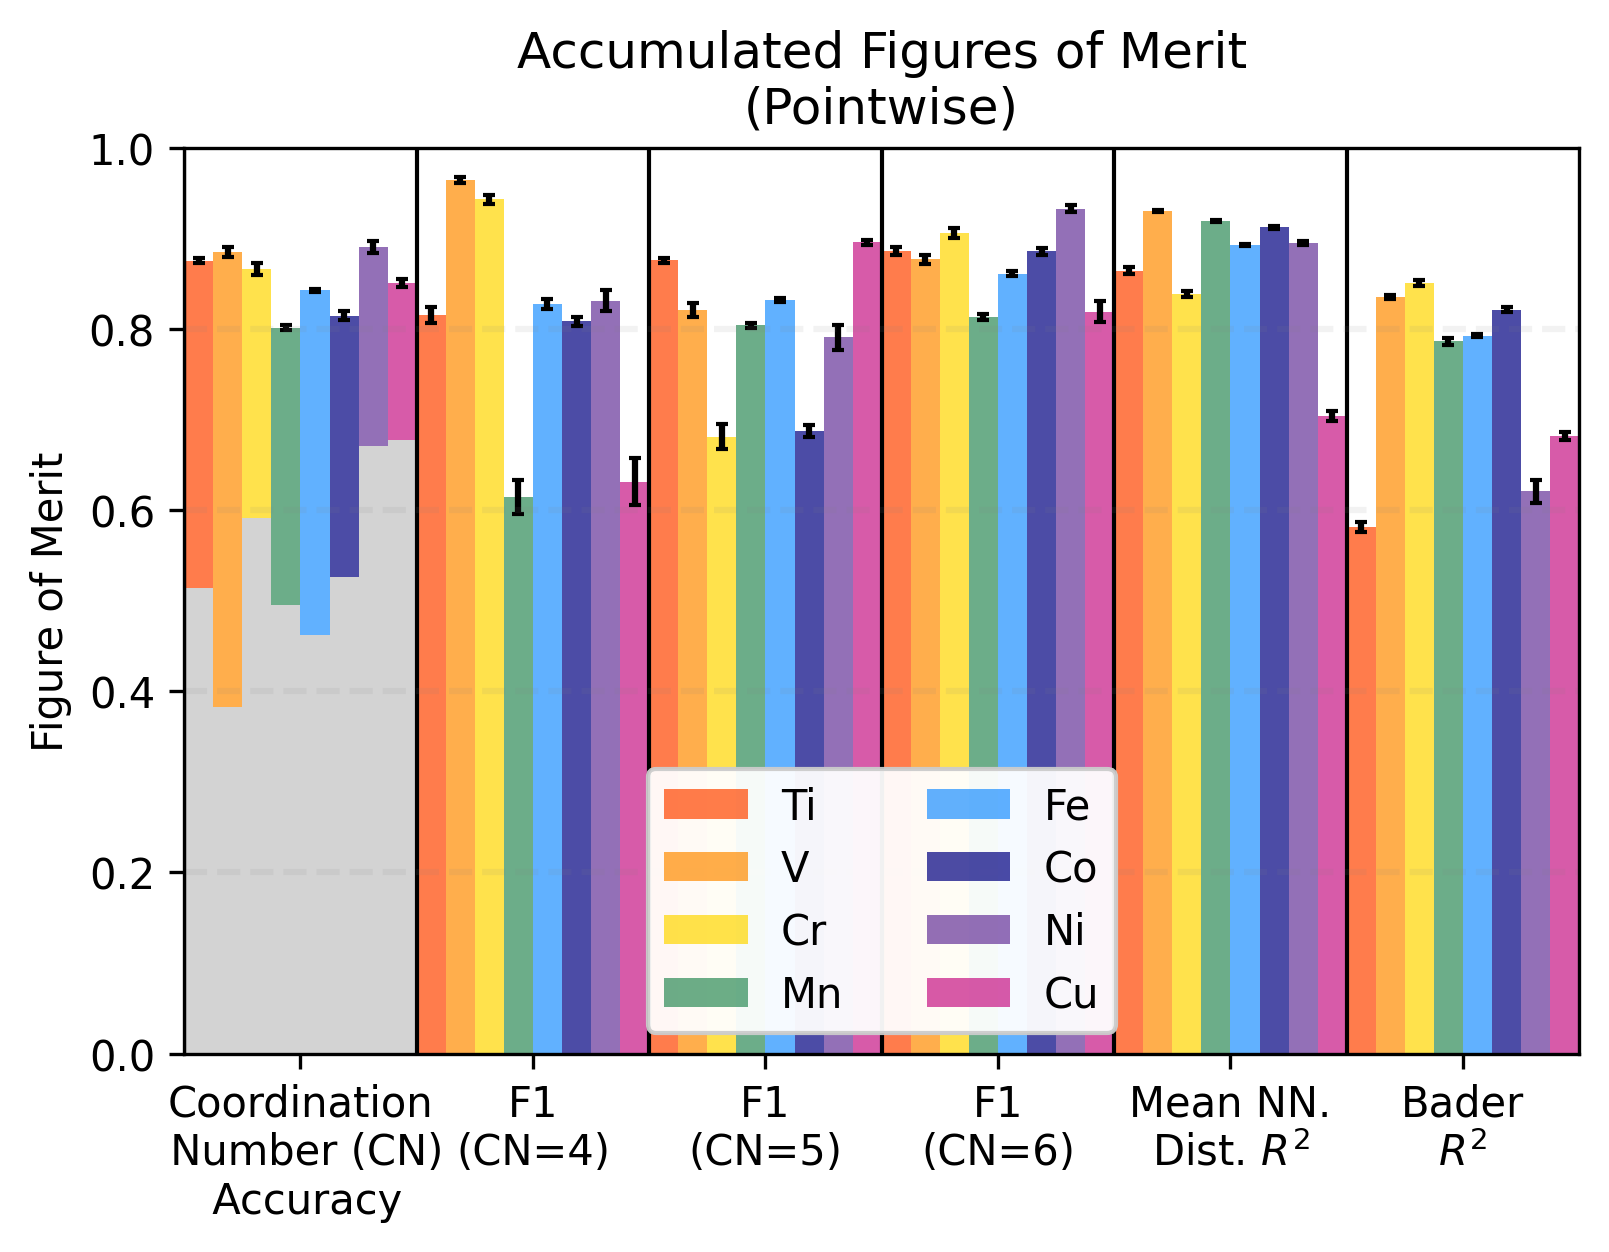

In [10]:

plt.figure(dpi=300)
for pj, pair in enumerate(target_elements_groups):
    
    
    
    plt.bar(pj+.5,accuracies[str(pair)+'-Coord']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           label=str(pair[0]),
           yerr = deviations[str(pair)+'-Coord']/100,capsize=1.5)
    plt.bar(pj+.5,accuracies[str(pair)+'-GuessMode']/100,color='lightgrey',width=1,alpha=1)
    plt.bar(pj+.5+8,accuracies[str(pair)+'-Coord-F1'][0]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][0]/100, capsize=1.5)
    
    plt.bar(pj+.5+2*8,accuracies[str(pair)+'-Coord-F1'][1]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][1]/100,capsize=1.5)
    
    plt.bar(pj+.5+3*8,accuracies[str(pair)+'-Coord-F1'][2]/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr = deviations[str(pair)+'-Coord-F1'][2]/100,capsize=1.5)
    
    plt.bar(pj+.5+4*8,accuracies[str(pair)+'-MeanDist']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations[str(pair)+'-MeanDist']/100,capsize=1.5)
    
    plt.bar(pj+.5+5*8,accuracies[str(pair)+'-Bader']/100,color=colors_by_pair[pair],width=1,alpha=.7,
           yerr =  deviations[str(pair)+'-Bader']/100,capsize=1.5)
    
    
    
    
for i in [0,8,16,24,32,40]:
    plt.axvline(i,color='black',lw=1,ls='-')

for i in [.2,.4,.6,.8]:
    plt.axhline(i,color='gray',ls='--',alpha=.1)

plt.xticks([8*i+4  for i in range(0,6)],
                labels=['Coordination\n Number (CN)\n Accuracy', 'F1\n(CN=4)', 'F1\n(CN=5)', 'F1\n(CN=6)',
                                      'Mean NN.\nDist. $R^2$','Bader\n$R^2$'],)
plt.xticks()
plt.xlim(0,6*7+6)
plt.ylim(0,1.0000001)
plt.ylabel('Figure of Merit')


plt.title("Accumulated Figures of Merit\n(Pointwise)")

plt.legend(loc='lower center',ncol=2,framealpha=.95)
plt.savefig(f'{figure_write_folder}/{norm_str}_all_perf.svg',format='svg',dpi=300,bbox_inches='tight',transprent=True)

# Performance of MD Fitting- Uniparity

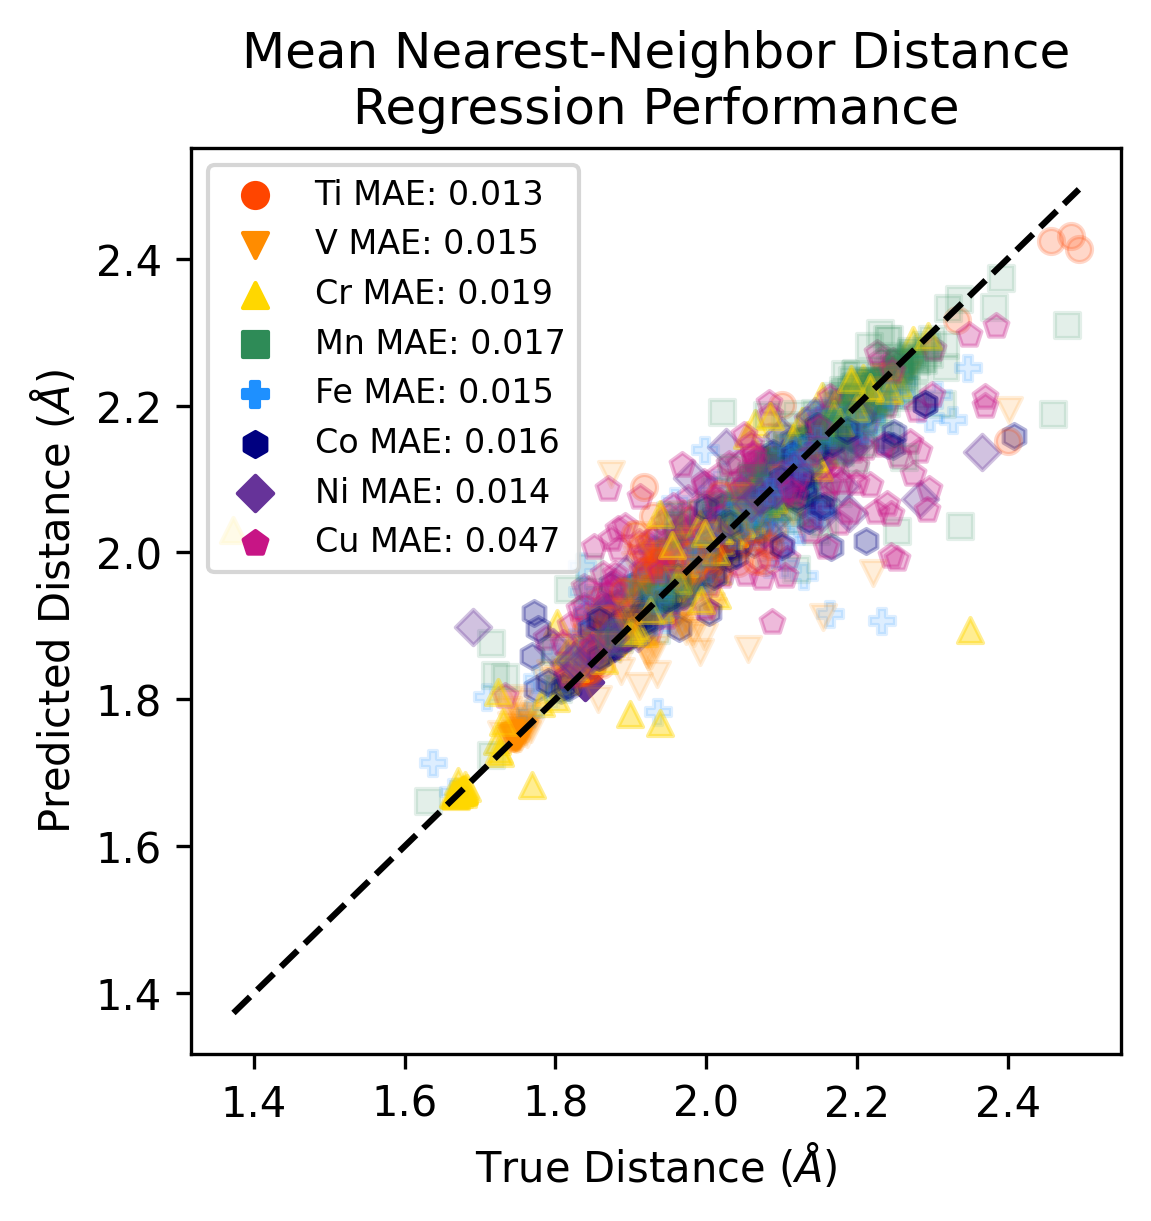

In [11]:

pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(md_perf_by_pair[pair[0]+'-guesses'])
    all_min = min(all_min, min(md_perf_by_pair[pair[0]+'-labels']),min(md_perf_by_pair[pair[0]+'-guesses']))
    all_max = max(all_max, max(md_perf_by_pair[pair[0]+'-labels']),max(md_perf_by_pair[pair[0]+'-guesses']))

    plt.scatter(md_perf_by_pair[pair[0]+'-labels'][0],
                    md_perf_by_pair[pair[0]+'-guesses'][0],
                    zorder=-1,
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 1,
                    label = pair[0] + " MAE: " +str(np.round((accuracies[str(pair)+'-MeanDist-MAE']),3)))
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(md_perf_by_pair[pair[0]+'-labels'][i],
                    md_perf_by_pair[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8)
plt.title("Mean Nearest-Neighbor Distance\nRegression Performance")
plt.xlabel("True Distance ($\AA$)")
plt.ylabel("Predicted Distance ($\AA$)")

plt.savefig(f'{figure_write_folder}/{norm_str}_md_uniparity.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

## Bader Performance

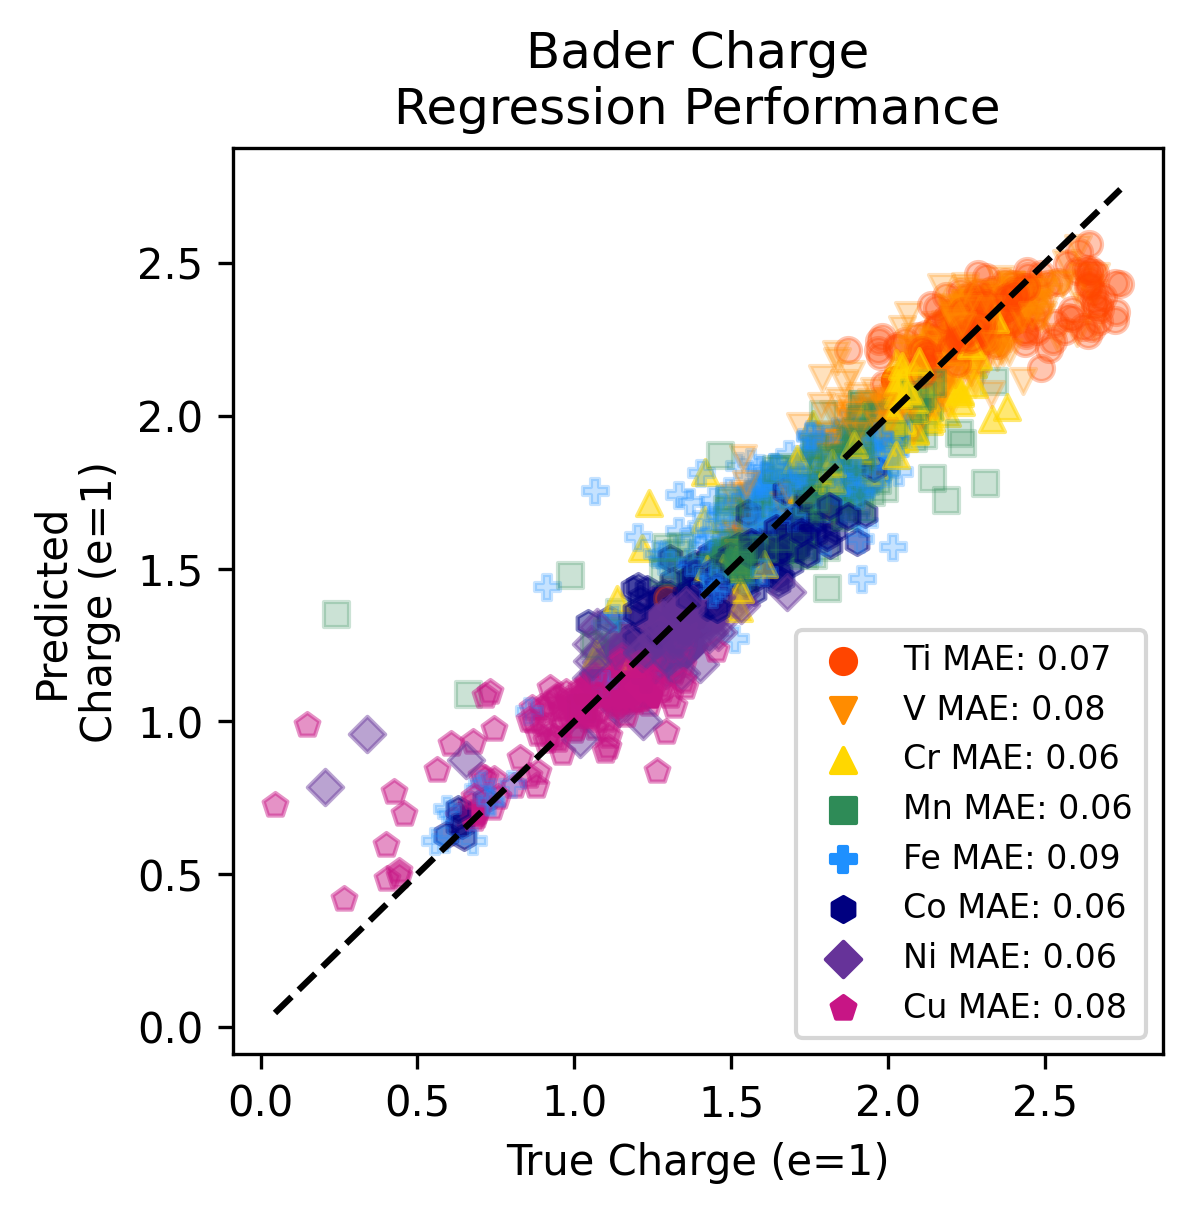

In [12]:

pair_to_icon={'Ti':"o",
              'V':'v',
              'Cr':'^',
              'Mn':"s",
              'Fe':"P",
              'Co':"h",
             'Ni':'D',
              'Cu':'p'}
all_min = 100
all_max = 0
plt.figure(figsize=(4,4),dpi=300)
for pair in target_elements_groups:
    number = len(bader_perf_by_pair[pair[0]+'-guesses'])
    all_min = min(all_min, min(bader_perf_by_pair[pair[0]+'-labels']),min(bader_perf_by_pair[pair[0]+'-guesses']))
    all_max = max(all_max, max(bader_perf_by_pair[pair[0]+'-labels']),max(bader_perf_by_pair[pair[0]+'-guesses']))

    plt.scatter(bader_perf_by_pair[pair[0]+'-labels'][0],
                bader_perf_by_pair[pair[0]+'-guesses'][0],
                zorder=-1,
                marker=pair_to_icon[pair[0]],
                color= colors_by_pair[pair], 
                alpha = 1,
                label=pair[0]+" MAE: "
                +str(np.round(accuracies[str(pair)+'-Bader-MAE'],2))) 
                #+f"\t R$^2$:{accuracies[str(pair)+'-Bader']:.2f}") 
    #print(number, len(md_perf_by_pair[pair[0]+'-labels']))
    for i in range(number)[1:]:
        plt.scatter(bader_perf_by_pair[pair[0]+'-labels'][i],
                    bader_perf_by_pair[pair[0]+'-guesses'][i],
                    zorder=np.random.uniform(0,1),
                    marker=pair_to_icon[pair[0]],
                    color= colors_by_pair[pair], 
                    alpha = 100/number)

plt.plot((all_min,all_max),(all_min,all_max),color='black',ls='--')
plt.legend(fontsize=8,loc='best')
plt.title("Bader Charge\nRegression Performance")
plt.xlabel("True Charge (e=1)")
plt.ylabel("Predicted\nCharge (e=1)")
plt.savefig(f'{figure_write_folder}/{norm_str}_bader_uniparity.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

--------------

#                     PART TWO: POLYNOMIALS

## Load in the Polynomial Fit Data

# The Big Cell - Polynomialized Data

# Polynomial Performance Table

--------------
# Part 3: Plotting Comparative Performance of Training & Testing, and Feature Importance


###  Feature Rank Function Definition

# Plot Change in Performance from Pointwise to Polynomial